In [23]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

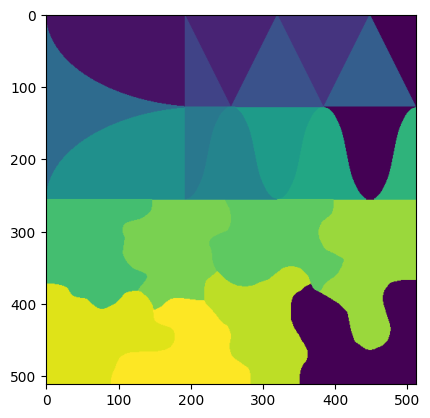

In [27]:
gt = skimage.measure.label(plt.imread('images/texmos3.s512.tiff')+1)
logits = np.load('tmp/logits.npy')
rlogits = np.array([skimage.transform.resize(logit, gt.shape, order=1, anti_aliasing=False) for logit in logits])
points = np.load('tmp/points.npy')
mean_scores = (np.load('tmp/stability_scores.npy') + np.load('tmp/predicted_ious.npy') ) / 2
plt.imshow(gt)

# improve 1click perf
1. select a click
2. get the highest scoring mask
3. threshold
4. get all clicks inside that mask
5. generate a new prediction by maximum certainty
6. threshold
7. go to step 4, repeat for many steps monitoring the loss against the pseudo-labeled mask and the difference between consecutive pseudo-labels


In [ ]:
# select a click

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return -np.log(1/x - 1)

iou_changes = []
for selected_point_ind in range(len(points)//3):
# for selected_point_ind in np.array([ 732,  964,  607,  785,  992,  631,  909,  580,  629,  946,  940,
#         683,  657, 1004,  860,  844,  659,  875,  713,  843,  558,  557,
#         723,  857,  837,  932,  716,  534,  618,  969,  924,  922, 1017,
#        1016,  849,  489,  920,  656,  423,  626,  606,  952,  548,  676,
#        1010,  638,  722,  609,  883,  708,  984,  711,  636,  575,  586,
#         545,  600,  813,  491,  836,  505,  997,  500,  562,  720,  661,
#         648,  642,  973,  674,  867,  440,  902,  576, 1023,  524,  928,
#         977,  865,  784,  466,  854,  878,  523,  453,  679,  520,  733,
#         957,  436,  250,  889,  882,  585,  470,  747,  265,  476,  895,
#         332])[32:64]:
    point = points[selected_point_ind]
    # get the ground truth
    gt_at_point = gt == gt[int(point[1]), int(point[0])]

    # get the highest scoring logit
    identical_points = (points == point.reshape(1,2)).all(axis=1)
    scores_for_logits_at_point = mean_scores[identical_points]
    best_logit_subind = np.argmax(scores_for_logits_at_point)
    current_logit = rlogits[identical_points][best_logit_subind] 
    current_mask = current_logit > 0
    initial = current_mask.copy()
    if current_mask[int(point[1]), int(point[0])] != True:
        print(f'selected point {point} with index {selected_point_ind} is not in the mask')
        iou_changes.append(0)
        continue

    ious = []
    diffs = []
    for step in range(4):
        intersection = np.sum(current_mask * gt_at_point)
        ious.append(intersection / (np.sum(current_mask) + np.sum(gt_at_point) - intersection))
        # threshold
        plabel = current_mask 

        # get clicks inside plabel
        points_inside_indices = np.array([ind for ind in range(len(points)) if plabel[int(points[ind][1]), int(points[ind][0])]])
        points_inside = points[points_inside_indices]
        points_inside_indices = []
        for point_inside in points_inside:
            idential_points = (points == point_inside.reshape(1,2)).all(axis=1)
            scores_for_logits_at_point = mean_scores[idential_points]
            best_logit_subind = np.argmax(scores_for_logits_at_point)
            points_inside_indices.append(np.arange(len(rlogits))[identical_points][best_logit_subind])
        points_inside_indices = np.array(points_inside_indices).flatten()

        # # visualize points
        # plt.figure()
        # plt.imshow(current_mask)
        # plt.scatter(points_inside[:, 0], points_inside[:, 1], color='blue', marker='x')
        # plt.scatter(point[0], point[1], color='red', marker='x')

        # logits that contain prompt
        crlogits = np.array([logit for logit in rlogits[points_inside_indices] if logit[int(point[1]), int(point[0])]>0])

        # # generate a new pred by maximum certainty
        # magnitudes = np.abs(crlogits)
        # max_mag_indices = np.argmax(magnitudes, axis=0)
        # h, w = rlogits.shape[1:]
        # y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        # new_mask = crlogits[max_mag_indices, y_coords, x_coords] > 0

        new_logit = np.mean([logit*sigmoid(current_logit[int(point[1]), int(point[0])]) for logit in rlogits[points_inside_indices] if logit[int(point[1]), int(point[0])]>0], axis=0) 
        new_mask = new_logit > 0
        diffs.append(np.sum(np.logical_xor(new_mask, current_mask)))
        current_logit = new_logit
        current_mask = new_mask
        if diffs[-1] == 0:
            break

    # plt.figure()
    # plt.plot(range(len(ious)), ious)
    # plt.title('IoU over iterations')
    # plt.figure()
    # plt.plot(range(len(diffs)), diffs)
    # plt.title('Diff over iterations')

    # # plot initial and final masks
    # final = current_mask.copy()
    # plt.figure()
    # plt.imshow(np.concatenate([initial, final], axis=1))
    # plt.scatter(point[0], point[1], color='red', marker='x')
    # plt.scatter(point[0]+initial.shape[1], point[1], color='red', marker='x')

    iou_changes.append(ious[-1] - ious[0])
    print(selected_point_ind, len(points)//3, np.mean(iou_changes), end='\r')

# -0.10719348186591302 for the certainty max approach
# -0.016456562123710848 for the mean approach 
# -0.0006992168839865091 for the modified mean approach (this is best so far, but still doesn't help)



selected point [ 72. 440.] with index 415 is not in the mask


Text(0.5, 1.0, 'mean = -0.016456562123710848')

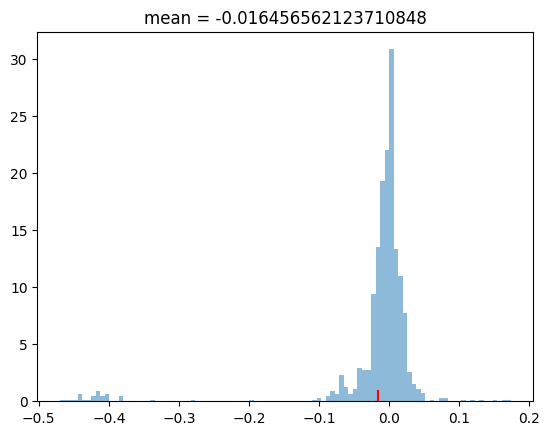

In [94]:
plt.figure()
plt.hist(iou_changes, bins=100, density=True, alpha=0.5)
plt.vlines([np.mean(iou_changes)], 0, 1, color='red')
plt.title(f'mean = {np.mean(iou_changes)}')

In [108]:
iou_changes_using_mean = np.array(iou_changes).copy()
np.argsort(iou_changes_using_mean)[:100]

array([ 732,  964,  607,  785,  992,  631,  909,  580,  629,  946,  940,
        683,  657, 1004,  860,  844,  659,  875,  713,  843,  558,  557,
        723,  857,  837,  932,  716,  534,  618,  969,  924,  922, 1017,
       1016,  849,  489,  920,  656,  423,  626,  606,  952,  548,  676,
       1010,  638,  722,  609,  883,  708,  984,  711,  636,  575,  586,
        545,  600,  813,  491,  836,  505,  997,  500,  562,  720,  661,
        648,  642,  973,  674,  867,  440,  902,  576, 1023,  524,  928,
        977,  865,  784,  466,  854,  878,  523,  453,  679,  520,  733,
        957,  436,  250,  889,  882,  585,  470,  747,  265,  476,  895,
        332])

## why doesn't it work?

recapping the method, it's a self-training loop where we estimate a mask, get the clicks inside it, and use them to re-estimate the mask. It doesn't really improve over the initial mask. Why? reason 1: we are comparing against an already decent mask, reason 2: there are two ways we can go wrong, either we overestimate the mask, in which case more clicks are added and we could expand the mask even more, or we underestimate the mask. The second reason in fact is something we could fix  with our method, but for the first we make it very much worse.

We know that superpixels do help, so IT IS possible to improve the mask. Now we want to find other methods. Specially mehtods that can improve while scaling inference time. Now we'll have to have a look at the changes in IoU to see where we fail the most. Taking the mean of the logits that include the current pixel is better than doing max certainty maps. 

# spectral clustering
one thing we could do is to say, ok, we have a grid of prompts, and we have an adjacency measure between any directed pair of them (and for simplicity we will assume only one logit map per prompt, the best one), so we can do graph clustering, in particular spectral clustering. 
1. select the best logit map for each prompt
2. compute the adjacency matrix between logit maps (which is the prob)
3. do spectral clustering (ng-jordan-weiss variant)


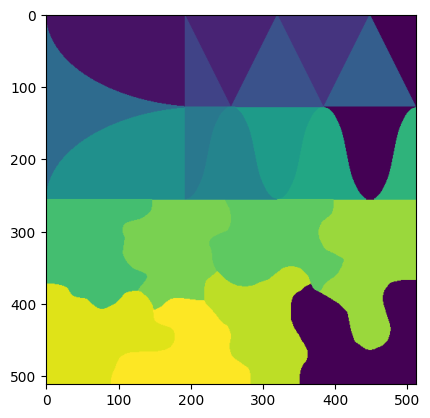

In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt

gt = skimage.measure.label(plt.imread('images/texmos3.s512.tiff')+1)
logits = np.load('tmp/logits.npy')
rlogits = np.array([skimage.transform.resize(logit, gt.shape, order=1, anti_aliasing=False) for logit in logits])
points = np.load('tmp/points.npy')
mean_scores = (np.load('tmp/stability_scores.npy') + np.load('tmp/predicted_ious.npy') ) / 2
plt.imshow(gt)

In [2]:
best_logits = []
unique_points = np.unique(points, axis=0)
for point in unique_points:
    identical_points = (points == point.reshape(1,2)).all(axis=1)
    scores_for_logits_at_point = mean_scores[identical_points]
    best_logit_subind = np.argmax(scores_for_logits_at_point)
    best_logit_at_point = logits[identical_points][best_logit_subind] 
    best_logits.append(best_logit_at_point)
best_logits = np.array(best_logits)
print('best logits shape', best_logits.shape)
print('unique points shape', unique_points.shape)

best logits shape (1024, 256, 256)
unique points shape (1024, 2)


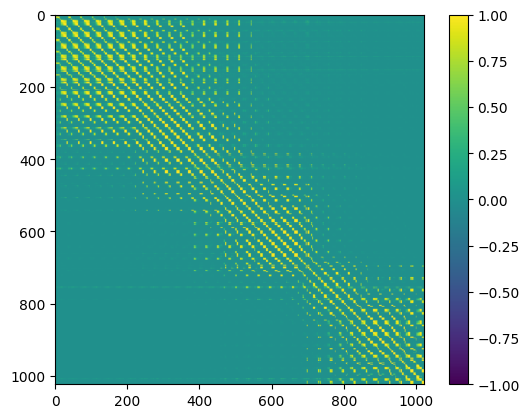

In [4]:
# now compute the adj matrix
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
adj = -np.ones((len(best_logits), len(best_logits)))
for i in range(len(best_logits)):
    for j in range(i, len(best_logits)):
        ds_point_i = unique_points[i][0] // 2, unique_points[i][1] // 2
        ds_point_j = unique_points[j][0] // 2, unique_points[j][1] // 2
        logit_i = best_logits[i]
        logit_j = best_logits[j]
        adj_i_j = sigmoid(logit_i[int(ds_point_j[1]), int(ds_point_j[0])])
        adj_j_i = sigmoid(logit_j[int(ds_point_i[1]), int(ds_point_i[0])])
        adj[i, j] = adj_i_j
        adj[j, i] = adj_j_i
plt.imshow(adj, vmin=-1, vmax=1)
plt.colorbar()


In [5]:
import numpy as np
from sklearn.cluster import KMeans
import time

def spectral_clustering_ng_jordan_weiss(adj, n_clusters):
    """
    Implementation of Ng-Jordan-Weiss spectral clustering.
    
    Parameters:
    - adj: Directed adjacency matrix with values in [0,1] (shape n×n)
    - n_clusters: Number of clusters to find
    
    Returns:
    - labels: Cluster assignments for each node
    """
    start_time = time.time()
    n = adj.shape[0]
    print(f"Starting spectral clustering for {n} nodes into {n_clusters} clusters")
    
    # Step 1: Convert directed adjacency to undirected by symmetrizing
    # This is common practice for directed graphs to use with spectral clustering
    A = (adj + adj.T) / 2
    print(f"Symmetrized adjacency matrix: {time.time() - start_time:.2f}s")
    
    # Step 2: Compute degree matrix D
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees + 1e-10))  # Add small constant to avoid division by zero
    print(f"Computed degree matrix: {time.time() - start_time:.2f}s")
    
    # Step 3: Compute normalized Laplacian L_sym = I - D^(-1/2) A D^(-1/2)
    L_sym = np.eye(n) - D_inv_sqrt @ A @ D_inv_sqrt
    print(f"Computed normalized Laplacian: {time.time() - start_time:.2f}s")
    
    # Step 4: Find the k smallest eigenvectors of L_sym
    eigen_time = time.time()
    eigenvalues, eigenvectors = np.linalg.eigh(L_sym)
    print(f"Eigendecomposition completed: {time.time() - eigen_time:.2f}s")
    
    # Step 5: Select the k smallest eigenvectors (skip the first one which should be ~0)
    indices = np.argsort(eigenvalues)[1:n_clusters+1]
    U = eigenvectors[:, indices]
    
    # Step 6: Normalize each row of U to have unit length
    row_norms = np.sqrt(np.sum(U**2, axis=1))
    U_normalized = U / row_norms[:, np.newaxis]
    print(f"Prepared embedding matrix: {time.time() - start_time:.2f}s")
    
    # Step 7: Cluster rows of U_normalized using k-means
    kmeans_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = kmeans.fit_predict(U_normalized)
    print(f"K-means clustering completed: {time.time() - kmeans_time:.2f}s")
    
    # Calculate some basic statistics about clusters
    cluster_sizes = np.bincount(labels, minlength=n_clusters)
    print(f"Cluster sizes: {cluster_sizes}")
    
    print(f"Total clustering time: {time.time() - start_time:.2f}s")
    
    return labels

cluster_labels = spectral_clustering_ng_jordan_weiss(adj, n_clusters=21)

Starting spectral clustering for 1024 nodes into 21 clusters
Symmetrized adjacency matrix: 0.02s
Computed degree matrix: 0.02s
Computed normalized Laplacian: 0.05s
Eigendecomposition completed: 0.18s
Prepared embedding matrix: 0.23s
K-means clustering completed: 0.14s
Cluster sizes: [54 86 40 76 66 68 69 62 60 36 57 33 33 30 40 32 26 32 16 20 88]
Total clustering time: 0.37s


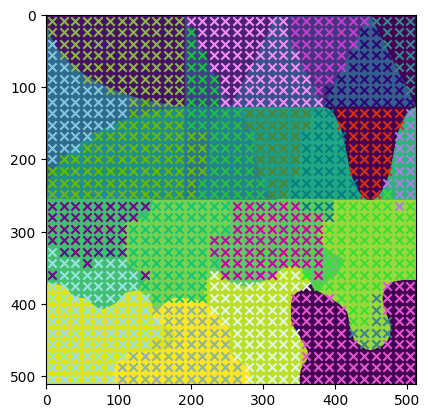

In [17]:
def random_rgb(input_label):
    np.random.seed(input_label)
    return np.random.rand(3)

plt.figure()
plt.imshow(gt)
mean_logits = []
for i in np.unique(cluster_labels):
    points_of_class = unique_points[cluster_labels == i]
    plt.scatter(points_of_class[:, 0], points_of_class[:, 1], color=random_rgb(i), marker='x', alpha=1)
    mean_logit = np.mean(best_logits[cluster_labels == i], axis=0)
    mean_logits.append(mean_logit)
mean_logits = np.array(mean_logits)

# plt.figure()
# plt.imshow(np.argmax(np.array(mean_logits)))


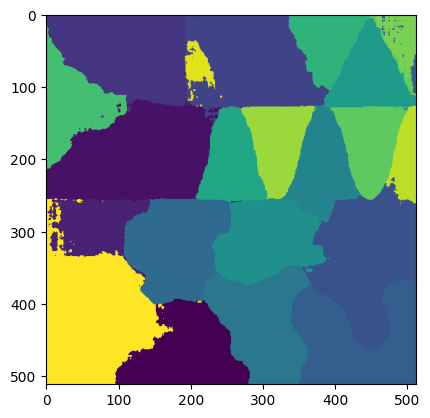

In [24]:
upsampled_mean_logits = np.array([skimage.transform.resize(logit, gt.shape, order=1, anti_aliasing=False) for logit in mean_logits])
argmax_labels = np.argmax(upsampled_mean_logits, axis=0)
plt.imshow(argmax_labels)
argmax_labels_as_channels = []
for label in np.unique(argmax_labels):
    mask = argmax_labels == label
    argmax_labels_as_channels.append(mask)
argmax_labels_as_channels = np.array(argmax_labels_as_channels)

In [25]:
# compute performance
for resized_logits in [upsampled_mean_logits, argmax_labels_as_channels]:
    sam2_ious = []
    print(f'resizing logits of shape {resized_logits.shape}...')
    print('calculating ious...')
    for gt_label in np.unique(gt):
        gt_mask = (gt == gt_label)  # ground truth mask
        best_iou = 0
        for resized_logit in resized_logits:
            intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
            if intersection == 0:
                continue
            union = np.logical_or(gt_mask, resized_logit > 0).sum()
            current_iou = intersection / union  
            if current_iou > best_iou:
                best_iou = current_iou
        sam2_ious.append(best_iou)
        print('gt label:', gt_label, 'iou:', current_iou, end='\r')
    print('mean iou:', np.mean(sam2_ious))

resizing logits of shape (21, 512, 512)...
calculating ious...
mean iou: 0.6332584425491503982456140595
resizing logits of shape (21, 512, 512)...
calculating ious...
mean iou: 0.735311034512907248921470398


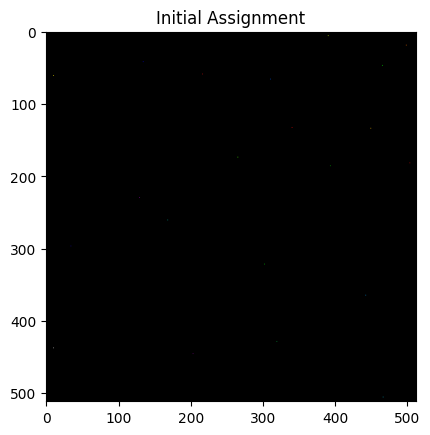

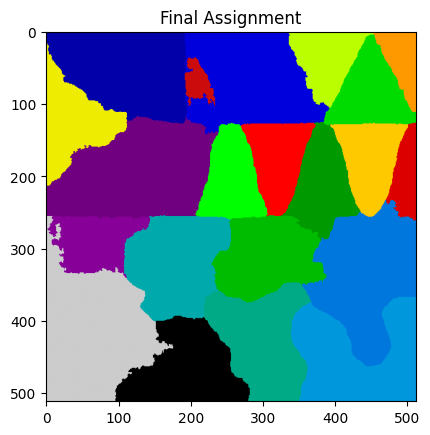

In [26]:
import numpy as np
import heapq

logits = upsampled_mean_logits
argmaxes = argmax_labels
# Assume logits is a numpy array of shape (C, H, W)
C, H, W = logits.shape

# Dictionary to hold seed information for each channel.
# The seed is defined by its coordinates and the logit value at that location.
labels = np.ones_like(argmaxes) * -1  # Initialize labels with -1

for c in range(C):
    # Get a boolean mask for pixels where channel c is the argmax.
    mask = (argmaxes == c)
    
    if np.any(mask):
        # For pixels in region c, get the corresponding logits (for channel c)
        channel_logits = logits[c]
        
        # Find the maximum logit value in the region where channel c is the argmax.
        max_val = np.max(channel_logits[mask])
        
        # Find the coordinates (first occurrence) of this maximum in the masked region.
        # np.argwhere returns coordinates in order [row, column] (i.e. [i, j])
        max_coords = np.argwhere((channel_logits == max_val) & mask)
        if max_coords.shape[0] > 0:
            # use the first occurrence as the seed for channel c
            seed_coords = tuple(max_coords[0])
            labels[seed_coords] = c

plt.figure()
plt.title("Initial Assignment")
plt.imshow(labels+1, cmap='nipy_spectral')

initial_assignment = labels.copy()
# Save the initial assignment



# Assume:
#   labels is a numpy array of shape (H, W) where seeds are labeled
#       with integers in 0..C-1 and unlabeled pixels are -1.
#   logits is a numpy array of shape (C, H, W)
#   argmaxes is a numpy array of shape (H, W)


H, W = labels.shape
C = logits.shape[0]

# Compute per-pixel optimal logit.
max_logits = np.max(logits, axis=0)  # shape: (H, W)

# regret_map stores the regret cost for each pixel.
regret_map = np.full((H, W), np.inf)
for i in range(H):
    for j in range(W):
        if labels[i, j] != -1:
            # If the pixel is labeled, its regret is 0 (it was perfectly assigned).
            regret_map[i, j] = 0

def get_neighbors(i, j):
    # 4-connected neighborhood.
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < H and 0 <= nj < W:
            yield ni, nj

def push_candidate(i, j, candidate_label):
    # Use the logits for the candidate contiguous label
    candidate_logit = logits[candidate_label, i, j]
    regret = max_logits[i, j] - candidate_logit
    if regret < regret_map[i, j]:  # if it lowers regret, consider it
        heapq.heappush(pq, (regret, candidate_label, (i, j)))

# Priority queue holds elements: (cumulative_cost, candidate_label, (i, j))
pq = []

# Initialize with seed pixels.
for i in range(H):
    for j in range(W):
        if labels[i, j] != -1:
            for ni, nj in get_neighbors(i, j):
                if labels[ni, nj] == -1:
                    # Push the candidate label for the neighbor.
                    push_candidate(ni, nj, labels[i, j])

# Main loop: process candidates by increasing regret.
while pq:
    regret, cand_label, (i, j) = heapq.heappop(pq)
    if not (regret < regret_map[i, j]) or not (cand_label != labels[i, j]):
        # if it doesn't improve regret or change the label, skip
        continue  
    # else we have a new label with lower regret
    labels[i, j] = cand_label
    regret_map[i, j] = regret
    for ni, nj in get_neighbors(i, j):
        push_candidate(ni, nj, cand_label)

# At the end, labels is fully filled.  Pixels may have been reassigned if a lower cost candidate was found.
plt.figure()
plt.title("Final Assignment")
plt.imshow(labels+1, cmap='nipy_spectral')
final_assignment = labels.copy()



In [28]:
argmax_labels_as_channels2 = []
for label in np.unique(final_assignment):
    mask = final_assignment == label
    argmax_labels_as_channels2.append(mask)
argmax_labels_as_channels2 = np.array(argmax_labels_as_channels2)
# compute performance
for resized_logits in [argmax_labels_as_channels2]:
    sam2_ious = []
    print(f'resizing logits of shape {resized_logits.shape}...')
    print('calculating ious...')
    for gt_label in np.unique(gt):
        gt_mask = (gt == gt_label)  # ground truth mask
        best_iou = 0
        for resized_logit in resized_logits:
            intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
            if intersection == 0:
                continue
            union = np.logical_or(gt_mask, resized_logit > 0).sum()
            current_iou = intersection / union  
            if current_iou > best_iou:
                best_iou = current_iou
        sam2_ious.append(best_iou)
        print('gt label:', gt_label, 'iou:', current_iou, end='\r')
    print('mean iou:', np.mean(sam2_ious))

resizing logits of shape (21, 512, 512)...
calculating ious...
mean iou: 0.7330347655722815204529351695


## does averaging work?
- compare mIoU @ 1 taking 1 point at random (on expectation) vs. the mean of all those points.
- basically that's comparing the performance of the mean of the predictions vs. the mean of the predictions' performances




In [31]:
print(best_logits.shape)
print(unique_points.shape)
print(gt.shape)
upsampled_best_logits = np.array([skimage.transform.resize(logit, gt.shape, order=1, anti_aliasing=False) for logit in best_logits])

def compute_iou(logit, target_mask):
    intersection = np.logical_and(target_mask, logit > 0).sum()
    if intersection == 0:
        return 0
    union = np.logical_or(target_mask, logit > 0).sum()
    current_iou = intersection / union
    return current_iou

individual_ious = {}
avg_ious = {}
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    individual_ious[gt_label] = []
    avg_logit = []
    for point_ind, unique_point in enumerate(unique_points):
        if gt_mask[int(unique_point[1]), int(unique_point[0])]:
            point_logit = upsampled_best_logits[point_ind]
            avg_logit.append(point_logit)
            individual_ious[gt_label].append(compute_iou(point_logit, gt_mask))
    avg_logit = np.mean(avg_logit, axis=0)
    avg_ious[gt_label] = compute_iou(avg_logit, gt_mask)

(1024, 256, 256)
(1024, 2)
(512, 512)


Text(0, 0.5, 'iou of avg logit')

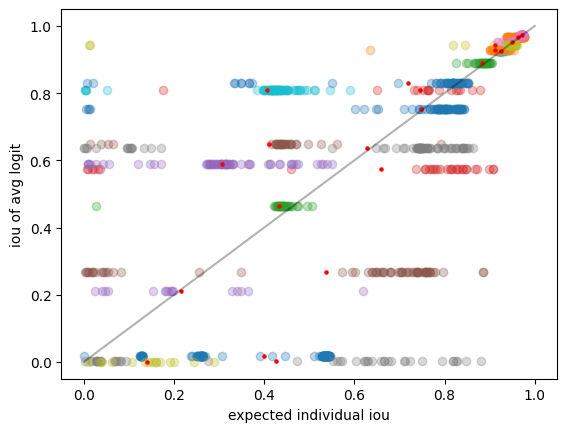

In [40]:
pairs = []
for gt_label in np.unique(gt):
    pairs.append((np.mean(individual_ious[gt_label]), avg_ious[gt_label]))
pairs = np.array(pairs)
plt.figure()
plt.plot([0, 1], [0, 1], color='black', alpha=0.3)
for ind, gt_label in enumerate(np.unique(gt)):
    plt.scatter(individual_ious[gt_label], pairs[ind, 1] * np.ones_like(individual_ious[gt_label]), alpha=0.3)
plt.scatter(pairs[:, 0], pairs[:, 1], color='red', alpha=1, s=5)
plt.xlabel('expected individual iou')
plt.ylabel('iou of avg logit')